# Preparing for colab

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/backups/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
!kaggle competitions download -c amex-default-prediction -f sample_submission.csv
!unzip /content/sample_submission.csv.zip

 31% 10.0M/32.4M [00:00<00:00, 102MB/s]
100% 32.4M/32.4M [00:00<00:00, 186MB/s]
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
!kaggle competitions download -c amex-default-prediction -f train_labels.csv
!unzip /content/train_labels.csv.zip

 74% 12.0M/16.2M [00:00<00:00, 123MB/s]
100% 16.2M/16.2M [00:00<00:00, 151MB/s]
Archive:  /content/train_labels.csv.zip
  inflating: train_labels.csv        


# Training & Inference

In [ ]:
!kaggle datasets download -d ryuina/amex-fe-plus2
!unzip /content/amex-fe-plus2.zip

100% 3.85G/3.85G [00:32<00:00, 140MB/s]
100% 3.85G/3.85G [00:32<00:00, 127MB/s]
Archive:  /content/amex-fe-plus.zip
  inflating: test_fe_plus_plus.parquet  
  inflating: train_fe_plus_plus.parquet  


In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc; gc.enable()
import joblib
import pickle
import random
import warnings
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')
from itertools import combinations
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

class CFG:
    input_dir = '/content/'
    seed = 42
    n_folds = 5
    target = 'target'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

### Training LightGBM (DART) Model

- Final predictions output uploaded as a public dataset. 

In [ ]:
seed_everything(CFG.seed)
train, test = read_data()

In [ ]:
# Label encode categorical features
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]
for cat_col in cat_features:
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])

# Round last float features to 2 decimal place
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
num_cols = [col for col in num_cols if 'last' in col]
for col in num_cols:
    train[col + '_round2'] = train[col].round(2)
    test[col + '_round2'] = test[col].round(2)

num_cols = [col for col in train.columns if 'last' in col]
num_cols = [col[:-5] for col in num_cols if 'round' not in col]
for col in num_cols:
    try:
        train[f'{col}_max-last'] = train[f'{col}_max'] - train[f'{col}_last']
        test[f'{col}_max-last'] = test[f'{col}_max'] - test[f'{col}_last']

        train[f'{col}_mean_min'] = train[f'{col}mean'] - train[f'{col}_min']
        test[f'{col}_mean_min'] = test[f'{col}_mean'] - test[f'{col}_min']

        train[f'{col}_last_mean'] = train[f'{col}_last'] - train[f'{col}_mean']
        test[f'{col}_last_mean'] = test[f'{col}_last'] - test[f'{col}_mean']
    except: pass

num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
for col in tqdm(num_cols):
    train[col] = train[col].astype(np.float16)
    test[col] = test[col].astype(np.float16)

# Get feature list
features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]

100%|██████████| 1638/1638 [09:28<00:00,  2.88it/s]


In [ ]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': CFG.seed,
    'num_leaves': 100,
    'learning_rate': 0.02,
    'feature_fraction': 0.20,
    'bagging_freq': 10,
    'bagging_fraction': 0.50,
    'n_jobs': -1,
    'lambda_l2': 2,
    'min_data_in_leaf': 40,
    # 'device_type': 'gpu'
    }

In [ ]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 8500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred

        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid, model
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

train_and_evaluate(train)

 
--------------------------------------------------
Training fold 0 with 2355 features...
[500]	training's binary_logloss: 0.257089	training's amex_metric: 0.790989	valid_1's binary_logloss: 0.261771	valid_1's amex_metric: 0.77888
[1000]	training's binary_logloss: 0.210214	training's amex_metric: 0.818916	valid_1's binary_logloss: 0.22335	valid_1's amex_metric: 0.792324
[1500]	training's binary_logloss: 0.195995	training's amex_metric: 0.838619	valid_1's binary_logloss: 0.218073	valid_1's amex_metric: 0.796908
[2000]	training's binary_logloss: 0.183219	training's amex_metric: 0.858856	valid_1's binary_logloss: 0.215344	valid_1's amex_metric: 0.7988
[2500]	training's binary_logloss: 0.174605	training's amex_metric: 0.87365	valid_1's binary_logloss: 0.214274	valid_1's amex_metric: 0.800435
[3000]	training's binary_logloss: 0.16538	training's amex_metric: 0.889078	valid_1's binary_logloss: 0.213609	valid_1's amex_metric: 0.800166
[3500]	training's binary_logloss: 0.156402	training's amex

In [ ]:
del train
_ = gc.collect()

# Test part

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [ ]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[231155, 231155, 231155, 231156]


In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
        
    # INFER XGB MODELS ON TEST DATA
    model = joblib.load(f'lgbm_fold0_seed{CFG.seed}.pkl')
    preds = model.predict(test_copy)
    for f in range(1,CFG.n_folds):
        model = joblib.load(f'lgbm_fold{f}_seed{CFG.seed}.pkl')
        preds += model.predict(test_copy)
    preds /= CFG.n_folds
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, model
    _ = gc.collect()

del test
_ = gc.collect()


Reading test data...
=> Test part 1 has shape (231155, 2355)

Reading test data...
=> Test part 2 has shape (231155, 2355)

Reading test data...
=> Test part 3 has shape (231155, 2355)

Reading test data...
=> Test part 4 has shape (231156, 2355)


# Submit

In [ ]:
# WRITE SUBMISSION FILE
test = pd.DataFrame(index=customers,data={'prediction': np.concatenate(test_preds)})
sub = pd.read_csv('sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_lgb_v1_seed{CFG.seed}_fold{CFG.n_folds}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.018484
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000489
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.031505
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.203642
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.899105


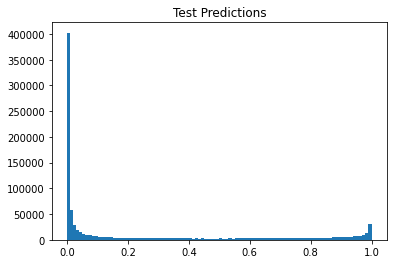

In [ ]:
# PLOT PREDICTIONS
import matplotlib.pyplot as plt
plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Prediction

In [ ]:
# Submit
!kaggle competitions submit -c amex-default-prediction -f submission_lgb_v1_seed42_fold5.csv -m "the first version. fe lag plus seed 52 fold 5 From colab"

100% 75.4M/75.4M [00:03<00:00, 23.8MB/s]
Successfully submitted to American Express - Default Prediction

In [ ]:
!kaggle competitions submissions amex-default-prediction

fileName                            date                 description                                               status    publicScore  privateScore  
----------------------------------  -------------------  --------------------------------------------------------  --------  -----------  ------------  
submission_lgb_v1_seed42_fold5.csv  2022-07-28 12:43:40  the first version. fe lag plus seed 52 fold 5 From colab  complete  0.798                      
submission_lgb_v1_seed42_fold5.csv  2022-07-28 05:46:49  the first version. fe lag plus seed 52 fold 5 From colab  complete  0.798                      
submission_xgb_v6_seed42_fold5.csv  2022-07-27 14:21:18  Run with (last - first) / s_2 seed 42 fold 5              complete  0.796                      
submission_cat_v1_seed42_fold5.csv  2022-07-27 09:46:57  Run with seed 42 fold 5 last / s2                         complete  0.796                      
submission_cat_v1_seed42_fold5.csv  2022-07-27 06:08:24  From colab seed 42 fold 5